In [1]:
import gym
import numpy as np
import random
#import csv
env = gym.make("Boxing-ram-v0")

In [2]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(18)
State Space Box(128,)


In [3]:
print(env.action_space)
print(env.observation_space.high)
print(env.observation_space.low)


Discrete(18)
[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [4]:
for i_episode in range(1):
    observation = env.reset()
    for t in range(1):
        print(observation)
        action = env.action_space.sample()
        print(action)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[ 68  12   0  40 214   3  14 244  16 244  13 244  15 244 255 160  27  89
   0   0  59   0   0   0   8   0   8   0   8   0   8   0  30 109   4  87
   0 245   0 247   0 245   0 246   0 255  72   0  18  32  20   2   0   0
   0   0   0   0   0   0   0   0   0   4  87   4  21  38   4  87 104 121
  87  95 159 191   0  95 159 191   0   0   0   0   0 208   0  43   0   1
  62   0   0   0 102  16   6  30   4 128   0 128   0 128   0 153   0 128
   0 128   0 254   0 140   0   0   0 120 243 109  86 243 104 120  63 246
 238 240]
6


In [5]:
def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

In [6]:
class QLearn:
    def __init__(self, actions, epsilon, alpha, gamma):
        self.q = {}
        self.epsilon = epsilon  # exploration constant
        self.alpha = alpha  # discount constant
        self.gamma = gamma  # discount factor
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        '''
        Q-learning:
            Q(s, a) += alpha * (reward(s,a) + max(Q(s') - Q(s,a))
        '''
        oldv = self.q.get((state, action), None)
        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def chooseAction(self, state, return_q=False):
        q = [self.getQ(state, a) for a in self.actions]
        maxQ = max(q)

        if random.random() < self.epsilon:
            minQ = min(q);
            mag = max(abs(minQ), abs(maxQ))
            # add random values to all the actions, recalculate maxQ
            q = [q[i] + random.random() * mag - .5 * mag for i in range(len(self.actions))]
            maxQ = max(q)
            # return random.choice(self.actions)

        count = q.count(maxQ)
        # In case there're several state-action max values
        # we select a random one among them
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            i = random.choice(best)
        else:
            i = q.index(maxQ)
        action = self.actions[i]
        if return_q:  # if they want it, give it!
            return action, q
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma * maxqnew)

In [7]:
import csv

def csv_log(episode, g):
    f = open(f'./log.csv', mode='a+')
    writer = csv.writer(f)
    writer.writerow([episode, g])
    f.close()

In [8]:
n_games = 2000
total_rewards = np.zeros(n_games)
def learn_one_episode(Q, episode):
  done = False
  G, reward = 0, 0
  state = env.reset()
  while not done:
      action = Q.chooseAction(build_state(state))
      state2, reward, done, info = env.step(action)
      Q.learn(build_state(state), action, reward, build_state(state))
      G += reward
      state = state2
  total_rewards[episode] = G
  csv_log(episode, G)
  print('Episode {} Total Reward: {}'.format(episode, G),"||", "Episode time: {}".format(time.strftime("%Mm %Ss", time.gmtime(time.time()-start_time))))

In [ ]:
n_games = 2000
total_rewards = np.zeros(n_games)

In [ ]:
import time
start_time = time.time()

Q = QLearn(list(range(0, 18)), 1, 0.5, 0.9)

for episode in range(n_games):
  learn_one_episode(Q, episode)

mean_rewards = np.zeros(n_games)
for t in range(n_games):
  mean_rewards[t] = np.mean(total_rewards[max(0, t-50) :(t+1)])

Episode 0 Total Reward: 0.0 || Episode time: 00m 02s
Episode 1 Total Reward: -6.0 || Episode time: 00m 04s
Episode 2 Total Reward: -2.0 || Episode time: 00m 06s
Episode 3 Total Reward: -9.0 || Episode time: 00m 08s
Episode 4 Total Reward: -3.0 || Episode time: 00m 11s
Episode 5 Total Reward: -1.0 || Episode time: 00m 13s
Episode 6 Total Reward: -5.0 || Episode time: 00m 15s
Episode 7 Total Reward: 9.0 || Episode time: 00m 17s
Episode 8 Total Reward: 3.0 || Episode time: 00m 20s
Episode 9 Total Reward: -9.0 || Episode time: 00m 22s
Episode 10 Total Reward: 1.0 || Episode time: 00m 24s
Episode 11 Total Reward: 2.0 || Episode time: 00m 26s
Episode 12 Total Reward: 4.0 || Episode time: 00m 29s
Episode 13 Total Reward: 5.0 || Episode time: 00m 31s
Episode 14 Total Reward: 2.0 || Episode time: 00m 33s
Episode 15 Total Reward: 12.0 || Episode time: 00m 35s
Episode 16 Total Reward: 3.0 || Episode time: 00m 38s
Episode 17 Total Reward: 5.0 || Episode time: 00m 40s
Episode 18 Total Reward: 0.0 |

Text(0.5, 1.0, 'Average Reward vs Episodes')

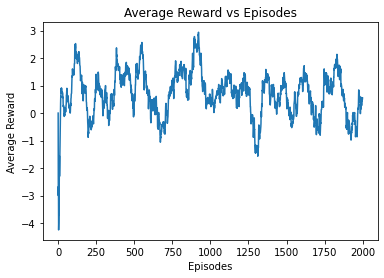

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [13]:
import time
start_time = time.time()

Q = QLearn(list(range(0, 18)), 0.9, 0.5, 0.9)

for episode in range(n_games):
  learn_one_episode(Q, episode)

mean_rewards = np.zeros(n_games)
for t in range(n_games):
  mean_rewards[t] = np.mean(total_rewards[max(0, t-50) :(t+1)])

Episode 0 Total Reward: 1.0 || Episode time: 00m 02s
Episode 1 Total Reward: 0.0 || Episode time: 00m 04s
Episode 2 Total Reward: 3.0 || Episode time: 00m 06s
Episode 3 Total Reward: -5.0 || Episode time: 00m 08s
Episode 4 Total Reward: -3.0 || Episode time: 00m 11s
Episode 5 Total Reward: 0.0 || Episode time: 00m 13s
Episode 6 Total Reward: 3.0 || Episode time: 00m 15s
Episode 7 Total Reward: 4.0 || Episode time: 00m 17s
Episode 8 Total Reward: 1.0 || Episode time: 00m 20s
Episode 9 Total Reward: 2.0 || Episode time: 00m 22s
Episode 10 Total Reward: 19.0 || Episode time: 00m 24s
Episode 11 Total Reward: 1.0 || Episode time: 00m 26s
Episode 12 Total Reward: 0.0 || Episode time: 00m 29s
Episode 13 Total Reward: 5.0 || Episode time: 00m 31s
Episode 14 Total Reward: 7.0 || Episode time: 00m 33s
Episode 15 Total Reward: 6.0 || Episode time: 00m 35s
Episode 16 Total Reward: 3.0 || Episode time: 00m 38s
Episode 17 Total Reward: -16.0 || Episode time: 00m 40s
Episode 18 Total Reward: 1.0 || E

Text(0.5, 1.0, 'Average Reward vs Episodes')

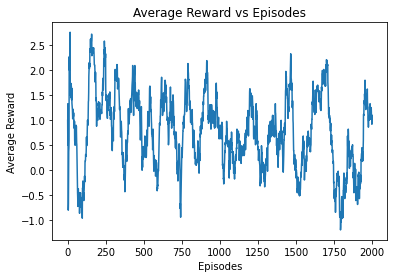

In [14]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [15]:
import time
start_time = time.time()

Q = QLearn(list(range(0, 18)), 0.9, 0.5, 0.3)

for episode in range(n_games):
  learn_one_episode(Q, episode)

mean_rewards = np.zeros(n_games)
for t in range(n_games):
  mean_rewards[t] = np.mean(total_rewards[max(0, t-50) :(t+1)])

Episode 0 Total Reward: -11.0 || Episode time: 00m 02s
Episode 1 Total Reward: 4.0 || Episode time: 00m 05s
Episode 2 Total Reward: 5.0 || Episode time: 00m 07s
Episode 3 Total Reward: 2.0 || Episode time: 00m 09s
Episode 4 Total Reward: 3.0 || Episode time: 00m 11s
Episode 5 Total Reward: 11.0 || Episode time: 00m 14s
Episode 6 Total Reward: -2.0 || Episode time: 00m 16s
Episode 7 Total Reward: 1.0 || Episode time: 00m 18s
Episode 8 Total Reward: 2.0 || Episode time: 00m 20s
Episode 9 Total Reward: 1.0 || Episode time: 00m 23s
Episode 10 Total Reward: 2.0 || Episode time: 00m 25s
Episode 11 Total Reward: 12.0 || Episode time: 00m 27s
Episode 12 Total Reward: 9.0 || Episode time: 00m 29s
Episode 13 Total Reward: -1.0 || Episode time: 00m 32s
Episode 14 Total Reward: 2.0 || Episode time: 00m 34s
Episode 15 Total Reward: -2.0 || Episode time: 00m 36s
Episode 16 Total Reward: 7.0 || Episode time: 00m 38s
Episode 17 Total Reward: 7.0 || Episode time: 00m 41s
Episode 18 Total Reward: 2.0 ||

Text(0.5, 1.0, 'Average Reward vs Episodes')

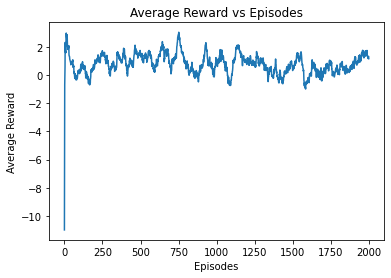

In [16]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [17]:
import time
start_time = time.time()

Q = QLearn(list(range(0, 18)), 0.9, 0.1, 0.9)

for episode in range(n_games):
  learn_one_episode(Q, episode)

mean_rewards = np.zeros(n_games)
for t in range(n_games):
  mean_rewards[t] = np.mean(total_rewards[max(0, t-50) :(t+1)])

Episode 0 Total Reward: 10.0 || Episode time: 00m 02s
Episode 1 Total Reward: 13.0 || Episode time: 00m 05s
Episode 2 Total Reward: 4.0 || Episode time: 00m 07s
Episode 3 Total Reward: -8.0 || Episode time: 00m 09s
Episode 4 Total Reward: 3.0 || Episode time: 00m 11s
Episode 5 Total Reward: 8.0 || Episode time: 00m 14s
Episode 6 Total Reward: -2.0 || Episode time: 00m 16s
Episode 7 Total Reward: -1.0 || Episode time: 00m 18s
Episode 8 Total Reward: 7.0 || Episode time: 00m 20s
Episode 9 Total Reward: 2.0 || Episode time: 00m 23s
Episode 10 Total Reward: -8.0 || Episode time: 00m 25s
Episode 11 Total Reward: 0.0 || Episode time: 00m 27s
Episode 12 Total Reward: 10.0 || Episode time: 00m 30s
Episode 13 Total Reward: -1.0 || Episode time: 00m 32s
Episode 14 Total Reward: 1.0 || Episode time: 00m 34s
Episode 15 Total Reward: 0.0 || Episode time: 00m 36s
Episode 16 Total Reward: 6.0 || Episode time: 00m 39s
Episode 17 Total Reward: 1.0 || Episode time: 00m 41s
Episode 18 Total Reward: -3.0 

Text(0.5, 1.0, 'Average Reward vs Episodes')

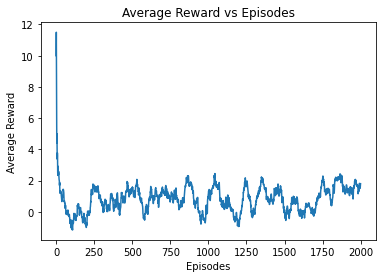

In [18]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [19]:
import time
start_time = time.time()

Q = QLearn(list(range(0, 18)), 0.9, 0.7, 0.5)

for episode in range(n_games):
  learn_one_episode(Q, episode)

mean_rewards = np.zeros(n_games)
for t in range(n_games):
  mean_rewards[t] = np.mean(total_rewards[max(0, t-50) :(t+1)])

Episode 0 Total Reward: 2.0 || Episode time: 00m 03s
Episode 1 Total Reward: 8.0 || Episode time: 00m 05s
Episode 2 Total Reward: 1.0 || Episode time: 00m 07s
Episode 3 Total Reward: 12.0 || Episode time: 00m 10s
Episode 4 Total Reward: -4.0 || Episode time: 00m 12s
Episode 5 Total Reward: 0.0 || Episode time: 00m 14s
Episode 6 Total Reward: 1.0 || Episode time: 00m 16s
Episode 7 Total Reward: 0.0 || Episode time: 00m 19s
Episode 8 Total Reward: -4.0 || Episode time: 00m 21s
Episode 9 Total Reward: -1.0 || Episode time: 00m 23s
Episode 10 Total Reward: 10.0 || Episode time: 00m 26s
Episode 11 Total Reward: 6.0 || Episode time: 00m 28s
Episode 12 Total Reward: -5.0 || Episode time: 00m 30s
Episode 13 Total Reward: 5.0 || Episode time: 00m 32s
Episode 14 Total Reward: -8.0 || Episode time: 00m 35s
Episode 15 Total Reward: -3.0 || Episode time: 00m 37s
Episode 16 Total Reward: -2.0 || Episode time: 00m 39s
Episode 17 Total Reward: -1.0 || Episode time: 00m 41s
Episode 18 Total Reward: 3.0

Text(0.5, 1.0, 'Average Reward vs Episodes')

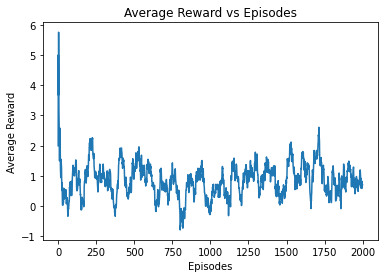

In [20]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [21]:
import time
start_time = time.time()

Q = QLearn(list(range(0, 18)), 0.2, 0.5, 0.9)

for episode in range(n_games):
  learn_one_episode(Q, episode)

mean_rewards = np.zeros(n_games)
for t in range(n_games):
  mean_rewards[t] = np.mean(total_rewards[max(0, t-50) :(t+1)])

Episode 0 Total Reward: -2.0 || Episode time: 00m 02s
Episode 1 Total Reward: -32.0 || Episode time: 00m 05s
Episode 2 Total Reward: -1.0 || Episode time: 00m 07s
Episode 3 Total Reward: 2.0 || Episode time: 00m 09s
Episode 4 Total Reward: 4.0 || Episode time: 00m 11s
Episode 5 Total Reward: 0.0 || Episode time: 00m 14s
Episode 6 Total Reward: 2.0 || Episode time: 00m 16s
Episode 7 Total Reward: 6.0 || Episode time: 00m 18s
Episode 8 Total Reward: 4.0 || Episode time: 00m 20s
Episode 9 Total Reward: 1.0 || Episode time: 00m 23s
Episode 10 Total Reward: 0.0 || Episode time: 00m 25s
Episode 11 Total Reward: -3.0 || Episode time: 00m 27s
Episode 12 Total Reward: -8.0 || Episode time: 00m 29s
Episode 13 Total Reward: 0.0 || Episode time: 00m 31s
Episode 14 Total Reward: 3.0 || Episode time: 00m 34s
Episode 15 Total Reward: -4.0 || Episode time: 00m 36s
Episode 16 Total Reward: -9.0 || Episode time: 00m 38s
Episode 17 Total Reward: -10.0 || Episode time: 00m 41s
Episode 18 Total Reward: 7.0

Text(0.5, 1.0, 'Average Reward vs Episodes')

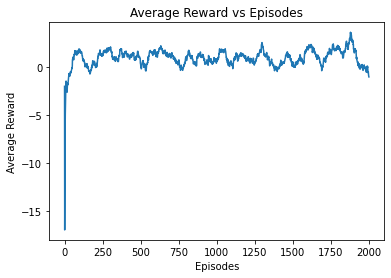

In [22]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [ ]:
Q.epsilon = 0.2
Q.alpha = 0.418
Q.gamma = 0.7

for episode in range(1, 1001):
  learn_one_episode(Q, episode)
  
Q.epsilon = 0.1
Q.alpha = 0.318
Q.gamma = 0.6

for episode in range(1, 1001):
  learn_one_episode(Q, episode)